In [114]:
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.feature_selection import RFE

import matplotlib.pyplot as plt
import numpy as np
import copy
import numbers

%matplotlib inline

In [115]:
def fix_data(data):
    """Convert dataframe to appropriate types"""
    for x in range(1,5):
        data.loc[data['Column3'] == x, 'Column3'] = str(x)

    num_col = [4, 5, 6, 8, 9, 10, 12]
    
    for col in num_col:
        col_name = 'Column'+str(col)
        data[col_name] = pd.to_numeric(data[col_name], errors='coerce')
    
    return data

def show_data(df, columns):
    data = copy.deepcopy(df)
    data.columns = columns
    
    return data

In [116]:
# data columns and read data from files

heart_disease = {}
heart_disease['columns_detail'] = [
    'Age', 
    'Sex', 
    'Pain type', 
    'Blood pressure', 
    'Serum cholesterol', 
    'Fasting blood sugar > 120mg/dl', 
    'Resting ECG', 
    'Max heart rate achieved', 
    'exercise induced agina', 
    'ST depression induced by exercise relative to rest', 
    'Peak exercise ST segment', 
    'Number of major vessels colored by flourosopy', 
    'Thal', 
    'Diagnosis'
]
heart_disease['train'] = pd.read_csv('../data/tubes2_HeartDisease_train.csv')
heart_disease['test'] = pd.read_csv('../data/tubes2_HeartDisease_test.csv')

In [117]:
heart_disease['train'] = fix_data(heart_disease['train'])
show_data(heart_disease['train'], heart_disease['columns_detail']).head()

,Age,Sex,Pain type,Blood pressure,Serum cholesterol,Fasting blood sugar > 120mg/dl,Resting ECG,Max heart rate achieved,exercise induced agina,ST depression induced by exercise relative to rest,Peak exercise ST segment,Number of major vessels colored by flourosopy,Thal,Diagnosis
0,54,1,4,125.0,216.0,0.0,0,140.0,0.0,0.0,?,NaN,?,1
1,55,1,4,158.0,217.0,0.0,0,110.0,1.0,2.5,2,NaN,?,1
2,54,0,3,135.0,304.0,1.0,0,170.0,0.0,0.0,1,0.0,3,0
3,48,0,3,120.0,195.0,0.0,0,125.0,0.0,0.0,?,NaN,?,0
4,50,1,4,120.0,0.0,0.0,1,156.0,1.0,0.0,1,NaN,6,3


In [118]:
data = heart_disease['train']
data.describe()

,Column1,Column2,Column4,Column5,Column6,Column8,Column9,Column10,Column12,Column14
count,779.000000,779.000000,732.000000,755.000000,701.000000,735.000000,735.000000,730.000000,265.000000,779.000000
mean,53.509628,0.779204,132.355191,200.309934,0.158345,138.348299,0.391837,3.937397,0.686792,0.989730
std,9.505017,0.415050,19.133545,109.938501,0.365325,26.087017,0.488493,7.788839,0.935422,1.138211
min,28.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,1.000000,120.000000,177.000000,0.000000,120.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,1.000000,130.000000,225.000000,0.000000,140.000000,0.000000,1.000000,0.000000,1.000000
75%,60.000000,1.000000,140.000000,270.000000,0.000000,159.000000,1.000000,2.950000,1.000000,2.000000
max,77.000000,1.000000,200.000000,529.000000,1.000000,202.000000,1.000000,62.000000,3.000000,4.000000


In [119]:
data = data.replace('?', np.nan)
data.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14
0,54,1,4,125.0,216.0,0.0,0,140.0,0.0,0.0,NaN,NaN,NaN,1
1,55,1,4,158.0,217.0,0.0,0,110.0,1.0,2.5,2,NaN,NaN,1
2,54,0,3,135.0,304.0,1.0,0,170.0,0.0,0.0,1,0.0,3,0
3,48,0,3,120.0,195.0,0.0,0,125.0,0.0,0.0,NaN,NaN,NaN,0
4,50,1,4,120.0,0.0,0.0,1,156.0,1.0,0.0,1,NaN,6,3


# Preprocess

In [120]:
data.isnull().sum()

Column1       0
Column2       0
Column3       0
Column4      47
Column5      24
Column6      78
Column7       2
Column8      44
Column9      44
Column10     49
Column11    262
Column12    514
Column13    408
Column14      0
dtype: int64

In [121]:
temp = data
temp.loc[temp['Column4'].isnull(), 'Column4'] = temp['Column4'].median()
temp.loc[temp['Column5'].isnull(), 'Column5'] = temp['Column5'].median()
temp.loc[temp['Column6'].isnull(), 'Column6'] = temp['Column6'].median()
temp.loc[temp['Column7'].isnull(), 'Column7'] = temp['Column7'].median()
temp.loc[temp['Column8'].isnull(), 'Column8'] = temp['Column8'].median()
temp.loc[temp['Column9'].isnull(), 'Column9'] = temp['Column9'].median()
temp.loc[temp['Column10'].isnull(), 'Column10'] = temp['Column10'].median()
temp.loc[temp['Column11'].isnull(), 'Column11'] = temp['Column11'].median()
temp.loc[temp['Column12'].isnull(), 'Column12'] = temp['Column12'].median()
temp.loc[temp['Column13'].isnull(), 'Column13'] = temp['Column13'].median()
temp.loc[temp['Column5'] == 0.0, 'Column5'] = temp['Column5'].median()
temp.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14
0,54,1,4,125.0,216.0,0.0,0,140.0,0.0,0.0,2,0.0,6,1
1,55,1,4,158.0,217.0,0.0,0,110.0,1.0,2.5,2,0.0,6,1
2,54,0,3,135.0,304.0,1.0,0,170.0,0.0,0.0,1,0.0,3,0
3,48,0,3,120.0,195.0,0.0,0,125.0,0.0,0.0,2,0.0,6,0
4,50,1,4,120.0,225.0,0.0,1,156.0,1.0,0.0,1,0.0,6,3


In [122]:
temp = temp.astype('float32')
temp.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11,Column12,Column13,Column14
0,54.0,1.0,4.0,125.0,216.0,0.0,0.0,140.0,0.0,0.0,2.0,0.0,6.0,1.0
1,55.0,1.0,4.0,158.0,217.0,0.0,0.0,110.0,1.0,2.5,2.0,0.0,6.0,1.0
2,54.0,0.0,3.0,135.0,304.0,1.0,0.0,170.0,0.0,0.0,1.0,0.0,3.0,0.0
3,48.0,0.0,3.0,120.0,195.0,0.0,0.0,125.0,0.0,0.0,2.0,0.0,6.0,0.0
4,50.0,1.0,4.0,120.0,225.0,0.0,1.0,156.0,1.0,0.0,1.0,0.0,6.0,3.0


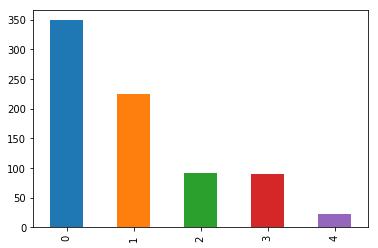

In [123]:
data['Column14'].value_counts().plot.bar()

In [124]:
#fill NaN with median

cv = 5
gnb = GaussianNB()

# train
X_train,X_test,y_train,y_test=X_train, X_test, y_train, y_test = train_test_split(temp.drop('Column14', axis=1), data.Column14,test_size=0.1)

gnb_f1_scores = cross_val_score(gnb, temp.loc[:, temp.columns != 'Column14']\
                , temp['Column14'], cv=cv, scoring='f1_micro')
gnb_accuracy_scores = cross_val_score(gnb, temp.loc[:, temp.columns != 'Column14']\
                , temp['Column14'], cv=cv, scoring='accuracy')
print("F1 Score: {:.4f} +- {:.4f}".format(gnb_f1_scores.mean(), gnb_f1_scores.std()))
print("Accuracy Score: {:.4f} +- {:.4f}".format(gnb_accuracy_scores.mean(), gnb_accuracy_scores.std()))

F1 Score: 0.5354 +- 0.0293
Accuracy Score: 0.5354 +- 0.0293
